In [1]:
from keras.models import Sequential
from keras import optimizers
from keras import models
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Dropout

import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
import joblib
from sklearn import preprocessing

Using TensorFlow backend.


In [22]:
group = 'D3h'
J = '7.5'
dir = '../ml_cr/TrainingData_{}_{}/'.format(group, J)
data = dir + 'generated_data_{}.csv'
targets = dir + 'generated_targets_{}.csv'

In [23]:
def cwt(data, channels=6, wavelet='morl'):
    """
    Applies the continuous wavelet transformation on each dataset (susc, spec heat, magnetization at 4 temps) individually
    and combines each convolution into a multi-channel image to be fed to the CNN
    Args:
        data: 1D array containing each dataset
        channels: number of channels in the output image (susc, spec heat, magnetization at 4 temps)
        waveletname: mother wavelet function to be used Can be any from 
            https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html, specifically pywt.wavelist()

    Returns:
        Input data reshaped into a (shape x shape) image with 'channels' channels
    """
    shape = data.shape[1]//channels
    size = data.shape[0]
    scales = np.arange(1, shape+1)

    data_cwt = np.ndarray(shape=(size, shape, shape, channels), dtype=np.float16)
    for i in range(size):
        if (i % 1000 == 0):
            print('.', end='')

        # generating each of the channels
        for j in range(channels):
            signal = data[i][j*shape: shape+(j*shape)]
            coeff, freq = pywt.cwt(signal, scales, wavelet, 1)
            data_cwt[i, :, :, j] = coeff

    return data_cwt

In [24]:
x_train = np.array(pd.read_csv(data.format(1000), header=None))
y_train = np.array(pd.read_csv(targets.format(1000), header=None))
channels = len(x_train[0])//64
x_train = cwt(x_train, channels=channels)

.

In [115]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train = np.array(pd.read_csv(data.format(50000), header=None))
y_train = np.array(pd.read_csv(targets.format(50000), header=None))
channels = len(x_train[0])//64

x_test = np.array(pd.read_csv(data.format(10000), header=None))
y_test = np.array(pd.read_csv(targets.format(10000), header=None))

In [ ]:
x_val = x_test[:2000]
x_test = x_test[2000:]
y_val = y_test[:2000]
y_test = y_test[2000:]

x_val = cwt(x_val, channels=channels)
print('x_val finished')
x_train = cwt(x_train, channels=channels)
print('x_train finished')
x_test = cwt(x_test, channels=channels)

# center the image data for each channel (mean of zero)
x_mean = np.mean(x_train, axis=(0,1,2), keepdims=True)
x_train -= x_mean
x_val -= x_mean
x_test -= x_mean

In [16]:
# normalize each of the targets (mean of zero and std of one)
y_mean = np.mean(y_train, axis=(0,), keepdims=True)
y_train -= y_mean
y_val -= y_mean
y_test -= y_mean
y_std = np.std(y_train, axis=(0,), keepdims=True)
y_train /= y_std
y_val /= y_std
y_test /= y_std

In [25]:
x_mean = np.load(dir + 'x_mean_{}_{}.npy'.format(group, J))
y_mean = np.load(dir + 'y_mean_{}_{}.npy'.format(group, J))
y_std = np.load(dir + 'y_std_{}_{}.npy'.format(group, J))

In [26]:
model = models.Sequential()

model.add(layers.Conv2D(96, (3, 3), activation='relu', input_shape=(64, 64, channels)))
model.add(layers.Conv2D(96, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Flatten())

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Dense(len(y_train[0])))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 96)        7872      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 96)        83040     
_________________________________________________________________
batch_normalization_6 (Batch (None, 60, 60, 96)        384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 256)       221440    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 256)       590080    
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 256)      

In [27]:
from keras.models import load_model
model = load_model(dir + '{}_{}_model.h5'.format(group, J))

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(x_train,
    y_train,
    epochs=2,
    batch_size=256,
    validation_data=(x_val, y_val))

average_mae_history = history.history['val_mae']
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [92]:
model.evaluate(example_x, (y_real-y_mean)/y_std)

1000/1000 [==============================] - 2s 2ms/step


[0.0007368448665365576, 0.02179691009223461]

In [28]:
y_real = np.array(pd.read_csv(targets.format(1000), header=None))
example_x = np.array(pd.read_csv(data.format(1000), header=None))

In [29]:
from sklearn import metrics
example_x = cwt(example_x, channels=channels)
example_x -= x_mean
y_pred = model.predict(example_x)
y_pred = (y_pred * y_std) + y_mean

.

In [30]:
for i in range(len(y_pred[0])-1):
    print('Mean absolute error: {}'.format(metrics.mean_absolute_error(y_real[:,i], y_pred[:,i])))
    print('Mean squared error: {}'.format(metrics.mean_squared_error(y_real[:,i], y_pred[:,i])))
    print('Explained varience score: {}'.format(metrics.explained_variance_score(y_real[:,i], y_pred[:,i])))
    print('r^2 score: {}'.format(metrics.r2_score(y_real[:,i], y_pred[:,i])))
    print()

Mean absolute error: 1.2345909945399978
Mean squared error: 2.646593237905732
Explained varience score: 0.9867384794211187
r^2 score: 0.9867368920927191

Mean absolute error: 0.026580836305217532
Mean squared error: 0.001222260063010131
Explained varience score: 0.9874499909025166
r^2 score: 0.9872465935108203

Mean absolute error: 0.029455464793611077
Mean squared error: 0.0016224000290071172
Explained varience score: 0.9848850758293958
r^2 score: 0.9835964687856661

Mean absolute error: 0.07585723929225915
Mean squared error: 0.01147894730882613
Explained varience score: 0.8879831144082396
r^2 score: 0.8846486577365793



In [31]:
res = pd.DataFrame()

for i in range(len(y_pred[0])):
    res['pred{}'.format(i)] = np.array(y_pred[:,i])
    res['real{}'.format(i)] = pd.DataFrame(y_real).reset_index(drop=True)[i]
    res['error{}'.format(i)] = res['pred{}'.format(i)] - res['real{}'.format(i)]

Text(0, 0.5, 'Absolute error')

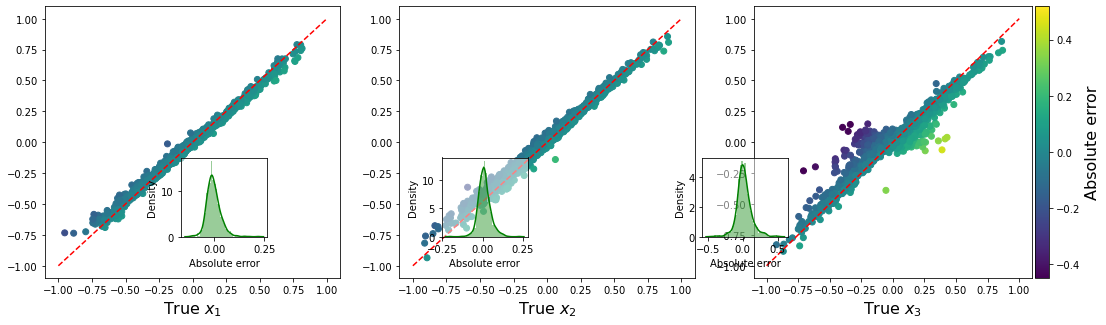

In [32]:
fig, ax = plt.subplots(ncols=len(y_pred[0])-2, nrows=1, figsize=(4*len(y_pred[0])-2,5)) #4 to tetra, 3.65 for hex
zs = np.array([])
for i in range(1, len(y_pred[0])-1):
    zs = np.concatenate([zs, res['error{}'.format(i)]], axis=0)
min_, max_ = zs.min(), zs.max()
norm = plt.Normalize(min_, max_)

for i in range(1, len(y_pred[0])-1):
    p = ax[i-1].scatter(res['real{}'.format(i)], res['pred{}'.format(i)], c=res['real{}'.format(i)]-res['pred{}'.format(i)], norm=norm)
    if (i > 0):
        ax[i-1].plot([-1, 1], [-1, 1], c='r', ls='--')
    else:
        ax[i-1].plot([0, 50], [0, 50], c='r', ls='--')
    ax2 = plt.axes([0.23+((i-1)*0.201), 0.24, 0.20/(len(y_pred[0])-2), 0.22]) # (0.23+((i-1)*0.201) for tetragonal
                                                                             # 0.27+((i-1)*0.27) for hex
    sns.distplot(res['error{}'.format(i)], color="g", kde=True, ax=ax2, norm_hist=True)
    ax2.set_xlabel('Absolute error')
    ax2.set_ylabel('Density')
    ax2.patch.set_alpha(0.5)
    
    ax[i-1].set_xlabel('True $x_{}$'.format(i), fontsize=16)

cb = colorbar(p, False)
cb.ax.set_ylabel('Absolute error', fontsize=16)

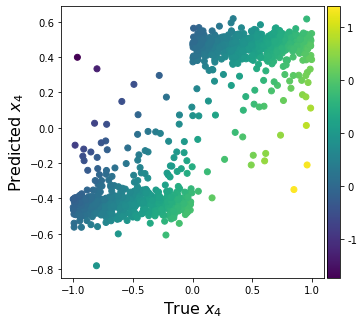

In [36]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
for i in range(1):
    i = 4
    p = ax.scatter(res['real{}'.format(i)], res['pred{}'.format(i)], c=res['real{}'.format(i)]-res['pred{}'.format(i)])

#     ax.plot([0, 50], [0, 50], c='r', ls='--')
    
ax.set_xlabel(f'True $x_{i}$', fontsize=16)
ax.set_ylabel(f'Predicted $x_{i}$', fontsize=16)
# ax2 = plt.axes([0.58, 0.24, 0.22, 0.22])
ax2.patch.set_alpha(0.5)
# sns.distplot(res['error0'], color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')
cb = colorbar(p, True)

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

last_real = [0 if i < 0 else 1 for i in y_real[:,len(y_pred[0])-1]]
last_pred = [0 if i < 0 else 1 for i in y_pred[:,len(y_pred[0])-1]]
report = classification_report(last_real, last_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       486
           1       0.98      0.97      0.97       514

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [ ]:
fig, ax = plt.subplots(ncols=len(y_pred[0]), nrows=1, figsize=(3.5*len(y_pred[0]),3.5))
for i in range(len(y_pred[0])):
    sns.distplot(y_real[:,i], color="g", kde=True, norm_hist=True, ax=ax[i])

In [121]:
for i in range(len(y_pred[0])):
    print('Mean absolute error: {}'.format(metrics.mean_absolute_error(y_real[:,i], y_pred[:,i])))
    print('Mean squared error: {}'.format(metrics.mean_squared_error(y_real[:,i], y_pred[:,i])))
    print('Explained varience score: {}'.format(metrics.explained_variance_score(y_real[:,i], y_pred[:,i])))
    print('r^2 score: {}'.format(metrics.r2_score(y_real[:,i], y_pred[:,i])))
    print()

Mean absolute error: 0.3533365881308148
Mean squared error: 0.19328830911037664
Explained varience score: 0.9990310386743984
r^2 score: 0.9990308119770476

Mean absolute error: 0.016219513458831367
Mean squared error: 0.0004253376898272836
Explained varience score: 0.9986735377807228
r^2 score: 0.998670989477171



In [13]:
def colorbar(mappable, ints):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(position="right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if (ints):
        cax.set_yticklabels(['{:,}'.format(int(x)) for x in cax.get_yticks().tolist()])
    plt.sca(last_axes)
    return cbar

Text(0, 0.5, 'Density')

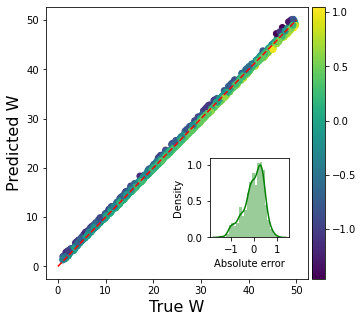

In [123]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
ax2 = plt.axes([0.58, 0.24, 0.22, 0.22])
# ax3 = plt.axes([0.735, 0.22, 0.12, 0.24])
# fig.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=None, hspace=None)
error0 = y_real[:,0]-y_pred[:,0]
error1 = y_real[:,1]-y_pred[:,1]
# df['Target'] = df['Target'].astype('category')

p1 = ax.scatter(y_real[:,0], y_pred[:,0], c=error0)
cb = colorbar(p1, False)
# cb.ax.set_ylabel('Absolute error')

ax.set_xlabel('True W', fontsize=16)
ax.set_ylabel('Predicted W', fontsize=16)
# legend1 = ax[0].legend(*p1.legend_elements(num=5), loc='upper left', title='Absolute error')
ax.plot([0, 50], [0, 50], c='r', ls='--')





sns.distplot(error0, color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')



https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/
https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/
https://stackoverflow.com/questions/54525136/numpy-normalize-rgb-image-dataset

Text(0, 0.5, 'Density')

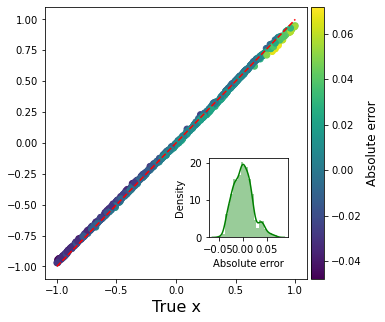

In [126]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
ax2 = plt.axes([0.58, 0.24, 0.22, 0.22])

p2 = ax.scatter(y_real[:,1], y_pred[:,1], c=error1)
cb2 = colorbar(p2, False)
cb2.ax.set_ylabel('Absolute error', fontsize=12)
# legend2 = ax[1].legend(*p2.legend_elements(num=6), loc='upper left', title='Absolute error')
ax.set_xlabel('True x', fontsize=16)
# ax[1].set_ylabel('Predicted x', fontsize=14)
ax.set_ylim(-1.1, 1.1)
ax.plot([-1, 1], [-1, 1], c='r', ls='--')

sns.distplot(error1, color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')